# MP2 - Deconvolution

----------------

# Contents:
- **2D Deconvolution using Richardson-Lucy (RL) Algorithm [45 points]**
    - Implement RL algorithm [30]
    - Apply and visualize (2D astro image) [5]
    - Find plausible PSF for a given noisy brain image, comment, and plot [10]
- **3D Convolution [35 points]**
    - Implement 3D convolution [30]
    - Compare implementation with scipy [5]
- **3D Deconvolution using RL Algorithm [20 points]**
    - Implement 3D RL algorithm [15]
    - Apply and visualize (3D brain volumes) [5]
----------------

# [Section] 2D Deconvolution using Richardson-Lucy (RL) Algorithm [45 points]

In [1]:
!pip install scikit-image
!curl https://upload.wikimedia.org/wikipedia/commons/0/03/T1-weighted-MRI.png --output brain_MRI.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 87581  100 87581    0     0   441k      0 --:--:-- --:--:-- --:--:--  447k


## Put your ```convolution2d``` function from MP1 in the cell below


In [1]:
def convolve2D(image, kernel, padding=0, strides=1):
    '''
    Returns the result Y = image * kernel, where * is the 2-D convolution operator.

        Parameters:
                image (ndarray): 2-D input image/signal
                kernel (ndarray): 2-D convolution kernel/signal

        Returns:
                Y (ndarray): 2-D convolution result similar to "same" mode in scipy/numpy.
    '''
    IH, IW = image.shape
    KH, KW = kernel.shape
    PH = KH // 2
    PW = KW // 2
    kernel = np.flipud(np.fliplr(kernel))


    padded_image = np.zeros((IH + 2 * PH, IW + 2 * PW))
    padded_image[PH:IH + PH, PW:IW + PW] = image
    Y = np.zeros((IH, IW))

    for i in range(IH):
        for j in range(IW):
              Y[i, j] = np.sum(padded_image[i:i+KH, j:j+KW] * kernel)

    return Y

### [Exercise] Implement the Richardson-Lucy deconvolution algorithm [30]
You should use your `convolve2D` function in the implementation. 

**Hint:** Make sure to use 'same' padding so that the convolution result has the same shape after each iteration.

In [7]:
import numpy as np

def richardson_lucy(image, psf, num_iter=50, eps=1e-12):
    """
    Richardson-Lucy deconvolution.

    Parameters:
    image (ndarray): Input degraded image (can be N-dimensional).
    psf (ndarray): The point spread function.
    num_iter (int): Number of iterations. Default is 50.
    eps (float): Value below which intermediate results become 0 to avoid division by small numbers. Default is 1e-12.

    Returns:
    ndarray: The deconvolved image.
    """
    result = np.full(image.shape, 0.5)
    psf_mirror = np.flipud(np.fliplr(psf))

    for _ in range(num_iter):
        convolved = convolve2D(result, psf)
        relative_blur = (image + eps) / (convolved + eps)
        correction = convolve2D(relative_blur, psf_mirror)
        result *= correction
    return result


Now let's try your R-L algorithm. First, load an image in grayscale.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())

Now manually add convolutional optical noise to the image by convolving the image with a point spread function (psf). Then add poisson noise to it.


In [9]:
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')

# add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

### [Exercise] Now apply the Richardson Lucy deconvolution algorithm, and plot the original image, the image with noise, and the deconvolution result. [5]

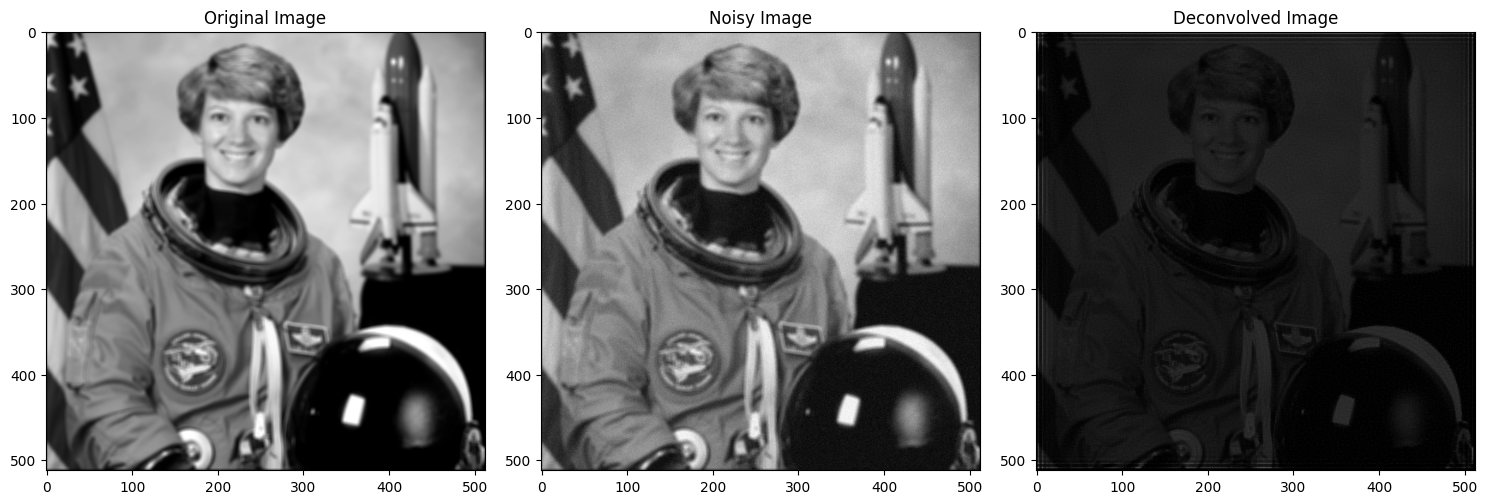

In [10]:
import matplotlib.pyplot as plt
from skimage import color, data
from scipy.signal import convolve2d as conv2

deconvolved_RL = richardson_lucy(astro_noisy, psf)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].imshow(astro, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(astro_noisy, cmap='gray')
ax[1].set_title("Noisy Image")
ax[2].imshow(deconvolved_RL, cmap='gray')
ax[2].set_title("Deconvolved Image")

plt.tight_layout()
plt.show()


Now that we have seen the power of the Richardson Lucy algorithm with artificial/known noise, let's try it out on an image with real unknown noise.

In [11]:
import PIL
brain = np.array(PIL.Image.open("brain_MRI.png"))

if len(brain.shape) > 2: # check if the picture has multiple color channels. If yes, convert to greyscale
    brain = color.rgb2gray(brain) 
    
brain = brain / 256.  # normalize the image pixel data to [0,1]
brain += 1E-12 # adding a small constant 1E-12 to avoid division-by-zero later down the line

### [Exercise] Since we do not know the real psf function in this case, we have to make a guess. Find the psf function which best models the real convolutional noise by trying different psf values in the cell below. [10]

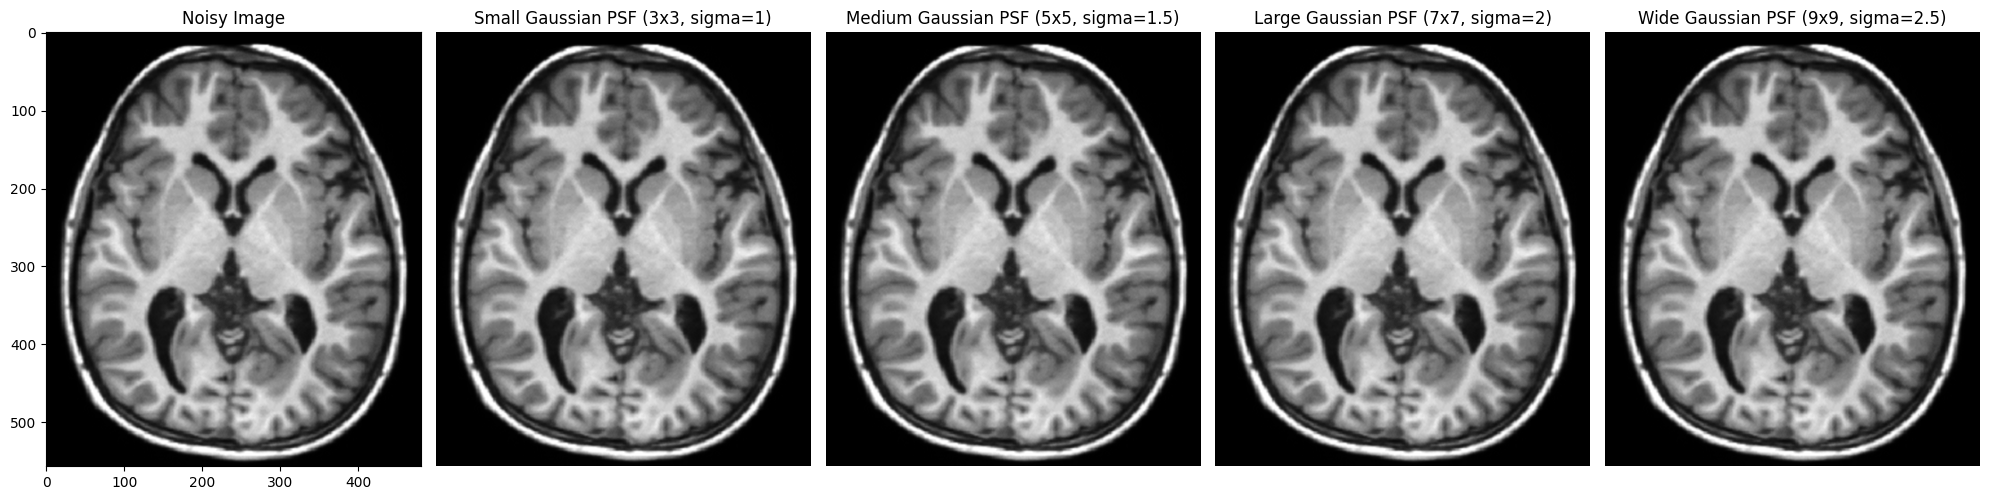

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import gaussian_filter

def generate_psf(size, sigma):
    psf = gaussian_filter(np.zeros((size, size)), sigma=sigma)
    psf[size // 2, size // 2] = 1
    return psf / psf.sum()

psf_options = {
    "Small Gaussian PSF (3x3, sigma=1)": generate_psf(size=3, sigma=1),
    "Medium Gaussian PSF (5x5, sigma=1.5)": generate_psf(size=5, sigma=1.5),
    "Large Gaussian PSF (7x7, sigma=2)": generate_psf(size=7, sigma=2),
    "Wide Gaussian PSF (9x9, sigma=2.5)": generate_psf(size=9, sigma=2.5)
}

fig, axes = plt.subplots(1, len(psf_options) + 1, figsize=(20, 5))
axes[0].imshow(brain, cmap='gray')
axes[0].set_title("Noisy Image")

for i, (psf_name, psf) in enumerate(psf_options.items(), 1):
    deconvolved = richardson_lucy(brain, psf)
    axes[i].imshow(deconvolved, cmap='gray')
    axes[i].set_title(f"{psf_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Q:** What did you observe when trying different point spread functions? Can you explain your observations?

**Your Answer:**

With big PSF can reduce noise better than small PSF, but hard to retain fine details.
Smaller PSF on the other hand, is more prone to noise, but can capture small details.

--------------------
# [Section] 3D Convolution [35 points]

Now let's apply the Richardson-Lucy algorithm in the 3-D space. 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve as scipy_convolve

### [Exercise] Implement the 3D convolution [30]

First, implement the 3-D convolution function in the cell below. Your implementation must support arbitrary padding modes.

In [52]:
def convolve3D(image, kernel, padding=0):
    '''
    convolve3D takes in the image array and the kernel array and convolves them
    with the padding scheme specified by parameter "padding"

    Input:
    image (Numpy.Array): 3-D image to be convolved
    kernel (Numpy.Array): 3-D kernel to be convolved
    padding (int): padding mode. default is 0

    Output:
    result (Numpy.Array): result of the convolution between image and kernel
    '''
    XL, YL, ZL = image.shape
    XK, YK, ZK = kernel.shape

    if padding == 'same':
        PX = (XK - 1) // 2
        PY = (YK - 1) // 2
        PZ = (ZK - 1) // 2
        padded_image = np.pad(image, ((PX, PX), (PY, PY), (PZ, PZ)), mode='constant')
    elif padding == 0:
        padded_image = image
    else:
        raise ValueError("Invalid padding option. Use 'same' or 0.")

    x_out = XL if padding == 'same' else XL - XK + 1
    y_out = YL if padding == 'same' else YL - YK + 1
    z_out = ZL if padding == 'same' else ZL - ZK + 1

    output = np.zeros((x_out, y_out, z_out))

    kernel_flipped = np.flip(kernel)

    for z in range(z_out):
        for y in range(y_out):
            for x in range(x_out):
                region = padded_image[x:x + XK, y:y + YK, z:z + ZK]
                output[x, y, z] = np.sum(region * kernel_flipped)

    return output

### [Exercise] Test your 3-D convolution function in the cell below. [5]

In [53]:
A = np.random.randint(0, 100, size=(30, 10, 18))
B = np.random.randint(0, 100, size=(5, 5, 3))

print("Correct (Scipy) Result:")
scipy_result = scipy_convolve(A, B, mode='valid')
print(scipy_result)

print()

print("Your Answer:")
your_result = convolve3D(A, B)
print(your_result)

print("\nYour result is {}".format("correct!" if np.array_equal(
    scipy_result, your_result) else "incorrect."))

Correct (Scipy) Result:
[[[206715 183910 177871 ... 189588 174353 179111]
  [193256 183037 183753 ... 189587 178769 178494]
  [193396 172657 163960 ... 183624 176340 180269]
  [175018 181501 166489 ... 172660 181328 186269]
  [181783 178067 167846 ... 171756 180030 197300]
  [180744 176173 188798 ... 173131 171346 188560]]

 [[211933 177165 194174 ... 185171 170866 168630]
  [193017 198204 178084 ... 162660 162136 177217]
  [180175 198641 169642 ... 179803 171496 189455]
  [180103 171514 174057 ... 189700 167820 182288]
  [193178 186441 168353 ... 177796 185388 176819]
  [176689 188635 176110 ... 180387 173387 182560]]

 [[186584 180116 179280 ... 180998 170383 179250]
  [179116 183131 171026 ... 184789 181423 163788]
  [181277 177870 153870 ... 180081 184256 173100]
  [179283 189102 175679 ... 172467 174659 180210]
  [171702 185432 165591 ... 175944 185251 172699]
  [197366 192744 178071 ... 172866 184099 191195]]

 ...

 [[161575 165676 168062 ... 158330 169573 178683]
  [167825 1571

You are encouraged to try different kernel sizes and padding modes to ensure your implementation is robust and general.

--------------

# [Section] 3D Deconvolution using RL Algorithm [20 points]

### [Exercise] Now with the 3D convolution function, implement the 3D Richardson-Lucy deconvolution algorithm. If your 3D convolution function does not work, use a library implementation instead. [15]

In [50]:
def richardson_lucy_3d(image, psf, padding, num_iter=30, eps=1e-12):
    """Richardson-Lucy deconvolution.
    Parameters
    ----------
    image : ndarray
      Input degraded image (can be N dimensional).
    psf : ndarray
      The point spread function.
    eps: float, optional
      Value below which intermediate results become 0 to avoid division
      by small numbers.
    padding: int
      Value depends on size of psf used. Use the padding size in the "same" padding mode.
    num_iter : int, optional
      Number of iterations. This parameter plays the role of
      regularisation.
    Returns
    -------
    im_deconv : ndarray
      The deconvolved image.
    """
    result = np.full(image.shape, 0.5)
    psf_mirror = np.flip(psf)

    for _ in range(num_iter):
        convolved = convolve3D(result, psf, padding='same')
        relative_blur = (image + eps) / (convolved + eps)
        correction = convolve3D(relative_blur, psf_mirror, padding='same')    
        result *= correction

    return result


In [31]:
import nibabel as nib
from skimage import color

!wget https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/raw/master/data/images/BRATS_001.nii.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [32]:
image_path = "BRATS_001.nii.gz"
image_obj = nib.load(image_path)
image_data = image_obj.get_fdata()
type(image_data)
print(image_data.shape)
image_data_by_channel = np.array([image_data[:, :, :, i] for i in range(4)])
print(image_data_by_channel.shape)

(240, 240, 155, 4)
(4, 240, 240, 155)


The amount of computation in 3D deconvolution / convolution is exponentially higher than in the 2D space. To save some time, let's shrink the image by downsampling it to a factor of 0.7 in the cell below. You may choose different factors to test your implementation faster.

In [33]:
from scipy.ndimage import zoom

image_data_by_channel = np.array(
    [zoom(channel, (0.7, 0.7, 0.7)) for channel in image_data_by_channel])

In [34]:
rng = np.random.default_rng()

psf = np.ones((5, 5, 5)) / 125

convolved_by_channel = [scipy_convolve(
    channel_slice, psf) for channel_slice in image_data_by_channel]

noisy_by_channel = convolved_by_channel.copy()

noisy_by_channel = [channel_slice + (rng.poisson(lam=125, size=channel_slice.shape) - 10 / 255)
                    for channel_slice in noisy_by_channel]

### [EXERCISE] Finally, let's apply your 3-D Richardson-Lucy deconvolution implementation to the noisy volumetric brain image.[5]

**(Warning - num_iter=1 in the cell below may take 3-6mins to run!)**

In [54]:
num_iter = 1

deconvolved_result = [richardson_lucy_3d(noisy_channel, psf, padding='same', num_iter=num_iter)
                          for noisy_channel in noisy_by_channel]

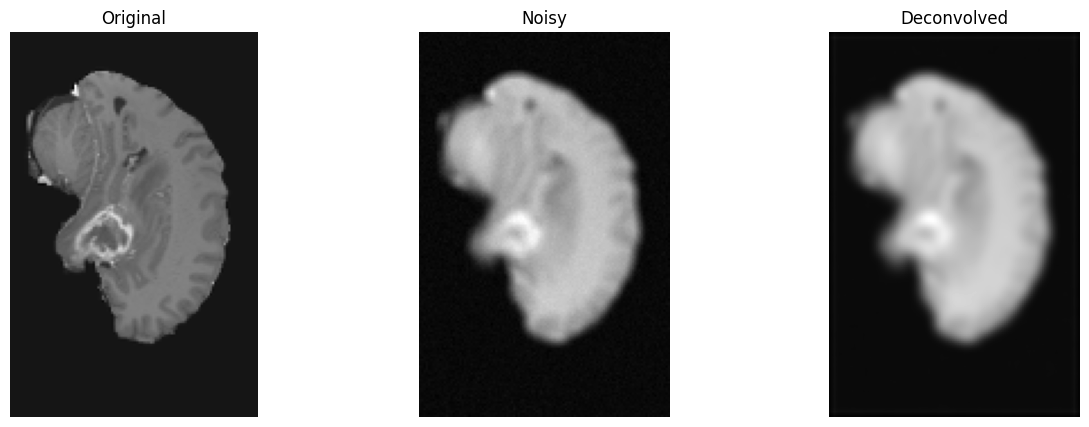

In [58]:
def display_deconvolution_comparison(layer_idx, channel_slice_idx):
    '''
    Display the original, noisy, and deconvolved image side-by-side given a particular 2D slice of the 4D brain image dataset.
    '''
    original = image_data_by_channel[channel_slice_idx][layer_idx, :, :]
    noisy = noisy_by_channel[channel_slice_idx][layer_idx, :, :]
    deconvolved = deconvolved_result[channel_slice_idx][layer_idx, :, :]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Noisy")
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Deconvolved")
    plt.imshow(deconvolved, cmap='gray')
    plt.axis('off')

    plt.show()

layer_idx = 100
channel_slice_idx = 2
display_deconvolution_comparison(layer_idx, channel_slice_idx)

-----------